# Assignment Living skin detection # 


## Authors: Jan Zahn, Jonas Meier, Thomas Wiktorin ##

## Task ##

Train a classifier which is able to distinguish between living and dead materials with highest success rate
The used NN should have few most distinctive input features i.e. spectral lines

Steps:

Read all XLS and CSV data files into Python.  
Visualize them and based on your insight suggest / try some decent feature classifiers.  
Select them, train them and validate them.  
Analyse runtime and memory footprint.  
Argue why your solution is appropriate.  

EXTENSION :
please implement and compare the "Living Skin" detection using  MLP and  SVMs and radial basis functions RBFs.  
Imporant metrics are especailly confusion-matrix, precsion and recall, many more may be runtime, memory foot step  
Train time etc  


## Explanation:##

BUG NOTE: We shuffle the data to get a normalised distribution of datatypes. Sometimes the random shuffle does not shuffle the the data-matrix and class-matrix the same way order, resulting in an unusable model with 50% accuraxy. If this happens, re-run the program.

In our first program we chose to use all 121 values on the input layer, and see how accurate our model is. We reached over 96 percent accuracy consistently. Using different sizes of epochs/batch_size/validation data/training data/test data/hidden layers did not change our results in huge ways. However, I believe the size of the hidden layers is better to be small due to overfitting.   

One problem existed in the unequal representation of classes. The "living Material" has just 6 examples, while the other class is represented by 171 data sets. To reach a high accuracy, our model just classified everything as "dead material" and had instant high training and validation accuracy. Of course, this accuracy is meaningless, since we are often interested in the under represented class.  

At first, we tried to weight our examples by the means of sensitivity and specificity.  

sensitivity = true positives / positives  
specificity = true negatives / negatives  

Our model always predicts dead material and therefore has a sensitivity of 0 and specificity of 1.  
We want to achieve a model that gets close to both sensitivity and specificity beeing 1.  

Weighting did not fix our issues, so we increased the number of positive examples by duplicating them, until the numbers for each class were equal.  
This fixed our issue and we got high accuracy (>95%) and a sensitivity & specificity value close to 1.

In the second program we reduced our number of features, otherwise it is the same. 
We reduced the input layer from 121 to 12.

We looked at the second derivative and the concavity (see program 2 graphs) seemed to provide a few distinct values, important for our few features. We chose the points where the second derivative is in its extremes for both min and max, resulting in a total of 12 points.   
This resulted in a higher accuracy (>98%) and a more stable learning (see last graphs in program two)  

Runtime for an prediction of our model with 12 features takes:  
0.0001302809675962635 seconds  
And with 121:  
0.0001329888860936989 seconds  
  
340 evaluations with 121 features take:  
0.00032795901779536507 seconds  
  
340 evaluations with 12 features take:  
0.000109520259115925  

We get a slight improvement, but with our data and network size, runtime and memory does not seem to matter much.

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import csv

#-------------------------------------------------------------------------------Get Data
dataFilesOldNegatives = ["Fleisch", "Holz", "Leder", "Stoff"]
dataFilesOldPositives = ["Referenz-Haut_6-Klassen"]

dataFilesNewNegatives = ["2016material", "2016material-fake"]
dataFilesNewPositives = ["2016skin"]

def importData(fileNames):
    data = np.array([]);
    xPoints = np.array([]);
    for dataType in fileNames:
        with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=';')
                
                newList = list(csv_reader)      
                for index, row in enumerate(newList):
                   newList[index] = [value.replace(',', '.') for value in row]
                
                newData = np.asarray(newList)
                newData = np.delete(newData, (0), axis=0)
                if xPoints.size == 0:
                    xPoints = newData[:,0]
                newData = np.delete(newData,(0), axis=1)
                
                if data.size == 0:
                    data = newData.transpose()
                else:
                    data = np.append(data, newData.transpose(),axis=0)
    
        data = data.astype(np.float)
        xPoints =  xPoints.astype(np.float)    
    return xPoints, data 


#Negatives Old
xValuesOld, dataNegativesOld = importData(dataFilesOldNegatives)

#Positives Old
_, dataPositivesOld = importData(dataFilesOldPositives)

#Negatives New
xValuesNew, dataNegativesNew = importData(dataFilesNewNegatives)

#Positives New
_, dataPositivesNew = importData(dataFilesNewPositives)

#Increase positives to deal with unbalance class (maybe not needed with 2016 set)
dataPositives = np.tile(dataPositivesOld,(28,1)) 

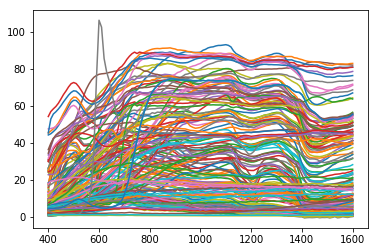

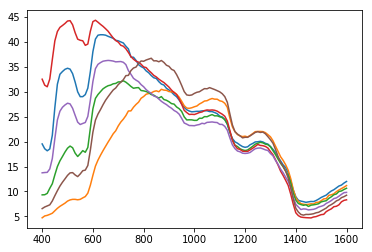

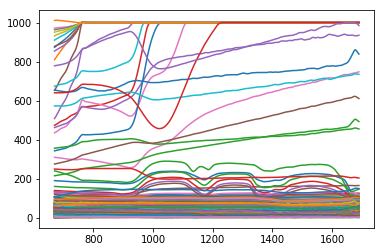

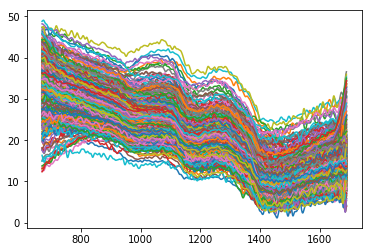

In [6]:
#--------------------------------------------------------------------------------Plott Data
def plottSpectrals(x,y):
    for row in y:
        plt.plot(x,row)
    plt.show()
        
plottSpectrals(xValuesOld,dataNegativesOld)
plottSpectrals(xValuesOld,dataPositivesOld)
plottSpectrals(xValuesNew,dataNegativesNew)
plottSpectrals(xValuesNew,dataPositivesNew)

In [7]:
#--------------------------------------------------------------------------------Some Information on Data
print("Old xValue data: " + str(xValuesOld.shape))
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print("New xValue data: " + str(xValuesNew.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))


Old xValue data: (121,)
Old negative data: (171, 121)
Old positive data: (6, 121)
New xValue data: (1031,)
New negative data: (367, 1031)
New positive data: (1111, 1031)


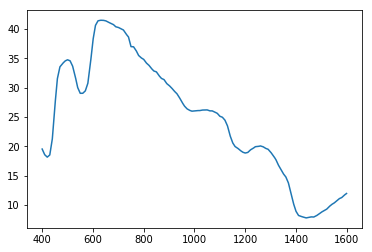

[19.53390957 18.5704303  18.15770953 18.52737077 21.26750017 26.84142289
 31.52784615 33.52835925 34.07154763 34.52047994 34.72839394 34.55235563
 33.64098217 31.95238109 29.99301753 29.0224614  29.02775248 29.437362
 30.73726427 34.05309372 38.05631633 40.58555823 41.36425805 41.4593598
 41.45175396 41.37321211 41.13741409 40.94128944 40.74950924 40.34931208
 40.23769832 40.01925357 39.79969363 39.15033676 38.61060154 36.96523504
 36.94120512 36.31096735 35.45914498 35.06268955 34.79498474 34.19849147
 33.8257814  33.26574433 32.82118606 32.66955155 32.03932137 31.5554658
 31.35634265 30.70410836 30.36394499 29.93597828 29.41050957 29.00915903
 28.35200154 27.57149798 26.87732403 26.39702406 26.13619879 25.981146
 26.03067793 26.083839   26.07689314 26.16937655 26.1851513  26.19452938
 26.03300851 26.02938973 25.83389189 25.60526577 25.11772241 24.94627023
 24.45124113 23.47870605 21.85019453 20.62656737 19.96152932 19.68578774
 19.30795689 19.00046435 18.85714985 18.95603656 19.37772

In [11]:
#---------------------------------------------------------------------------------Combine different Data
#New wavelength 400-1600 ;                           in steps of 10
#Old wavelength 670-1690 (everything after is NaN);  in steps of 1 

#Delete NaN at the end of new files
dataNegativesNew = dataNegativesNew[:,:xValuesNew.size-10]
dataPositivesNew = dataPositivesNew[:,:xValuesNew.size-10]

#InterpolateOldData to match new 
xValueAlteredOLd = np.asarray(range(400,1600))
testData = np.interp(xValueAlteredOLd,xValuesOld,dataPositivesOld[0,:])

#---------------------------------------------------------------------------------Print new data format
plt.plot(xValueAlteredOLd, testData)
plt.show()

print(dataPositivesOld[0,:])
print(testData)

print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))

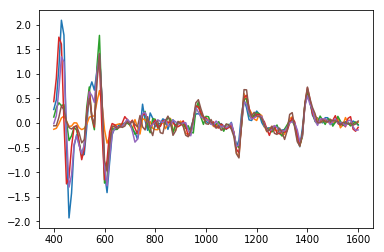

In [28]:
#---------------------------------------------------------------------------------New Features
#Extra Value for less Features (maybe)
gradientData = np.empty([dataPositivesOld.shape[0],dataPositivesOld.shape[1]]);
i = 0;
for row in dataPositivesOld:
    gradient = np.gradient(np.gradient(row)) #where does the gradient change fastest
    plt.plot(xValuesOld,gradient)
    gradientData[i] = gradient
    i = i+1
    
plt.show()

In [29]:
#--------------------------------------------------------------------------------Split Up Data
#hardcoded
maxGradients = gradientData.argmax(axis=1)
minGradients = gradientData.argmin(axis=1)
smallXValues = np.append(maxGradients,minGradients,axis=0)

smallFeaturesPositiveReal = dataPositivesOld[:,smallXValues]
smallFeaturesPositive = np.tile(smallFeaturesPositiveReal,(28,1)) #Increase positives to deal with unbalance class
smallFeature = dataNegativesOld[:,smallXValues]

#[1,0] is dead, [0.1] alive
#CompleteSet Small Version
compSet = np.append(smallFeature, smallFeaturesPositive ,axis=0)
classifcSet = np.append(np.tile([1,0],(smallFeature.shape[0],1)),np.tile([0,1],(smallFeaturesPositive.shape[0],1)),axis=0)

#shuffle data together
mix = np.random.permutation(len(compSet))
compSet = compSet[mix]
classifcSet = classifcSet[mix]

#Split in training and test Data
trainingSet = compSet[:200]
trainingLabelSet =  classifcSet[:200]

validationSet = compSet[200:300]
validationLabelSet = classifcSet[200:300]

testSet = compSet[300:]
testLabelSet = classifcSet[300:]

print(smallXValues.shape)
print(trainingSet.shape)
print(smallFeature.shape)

print(smallFeaturesPositive.shape)
print(smallFeature.shape)

(12,)
(200, 12)
(171, 12)
(168, 12)
(171, 12)


In [27]:
#--------------------------------------------------------------------------------Build Model with tensorflow

#Simple answer; number of input layer = number of points on spectral line
spectrum = 120 

model = keras.Sequential() #Single input-output
model.add(keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(12,))) #fully-conndected = dense, with 16 units, relu: rectified linear unit
model.add(keras.layers.Dense(2, activation=tf.nn.softmax)) #Cofidence level

model.summary()

#Optimizer and loss function
model.compile(optimizer=tf.train.AdamOptimizer(), #or sgd(stochastic gradient descent optimizer: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
              loss='binary_crossentropy', #or mean_squared_error (our target is not in the continuos space), but binary seems to deal better with probabilitis
              metrics=['accuracy']
              )

#Weighted class did not solve the unequal class problem
#class_weight={
#        1: 1/100, 2:1/2}

#Train model for 50 epochs in batches of 3 samples
history = model.fit(trainingSet,
                    trainingLabelSet,
                    epochs=50,
                    batch_size=10,  #the bigger the more memory space needed
                    validation_data=(validationSet, validationLabelSet),
                    verbose=1
                    )
                    

results = model.evaluate(testSet, testLabelSet)
print(results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 100 samples
Epoch 1/50
200/200 [==============================] - 0s 1ms/step - loss: 4.0831 - acc: 0.4850 - val_loss: 4.3504 - val_acc: 0.6200
Epoch 2/50
200/200 [==============================] - 0s 105us/step - loss: 3.2335 - acc: 0.5750 - val_loss: 3.2816 - val_acc: 0.5100
Epoch 3/50
200/200 [==============================] - 0s 110us/step - loss: 1.9965 - acc: 0.6600 - val_loss: 2.1048 - val_acc: 0.5000
Epoch 4/50
200/200 [==============================] - 0s 105us/step - loss: 1.2730 - acc: 0.64

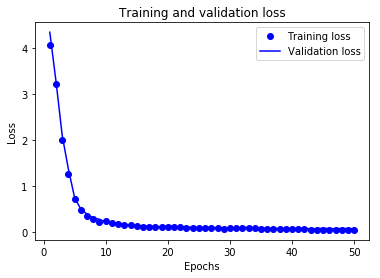

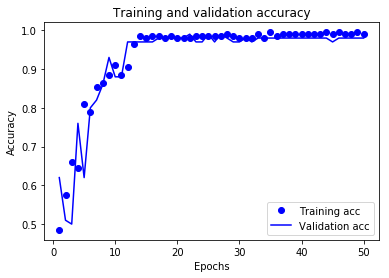

In [28]:

#--------------------------------------------------------------------------------Print Results
#Plot accuracy and loss over time
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [29]:
# ----------------------------------------------------Some Time estimation
import timeit

start = timeit.timeit()
result = model.predict(smallFeature)
end = timeit.timeit()
print(end - start)


1.8052768241579031e-06
